In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.linalg import toeplitz
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import RidgeCV
from sklearn.cluster import KMeans
from skimage.filters import threshold_triangle

sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

from bigbrain.brain import get_dims
from bigbrain.brain import bleaching_correction
from bigbrain.brain import z_score_brain
from bigbrain.brain import get_resolution
from bigbrain.brain import load_numpy_brain
from bigbrain.fictrac import load_fictrac
from bigbrain.fictrac import prep_fictrac
from bigbrain.utils import load_timestamps
from bigbrain.utils import get_fly_folders
from bigbrain.utils import send_email
from bigbrain.glm import fit_glm
from bigbrain.glm import save_glm_map
from bigbrain.motcorr import get_motcorr_brain

In [2]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
desired_flies = [i for i in range(1,27)] # 1 index
folders = get_fly_folders(root_path, desired_flies)

fly folders: ['fly_1', 'fly_2', 'fly_3', 'fly_4', 'fly_5', 'fly_6', 'fly_7', 'fly_8', 'fly_9', 'fly_10', 'fly_11', 'fly_12', 'fly_13', 'fly_14', 'fly_15', 'fly_16', 'fly_17', 'fly_18', 'fly_19', 'fly_20', 'fly_21', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']


In [3]:
fictracs = []
for i in range(len(folders)):
    try:
        fictracs.append(load_fictrac(root_path, folders[i]))
    except:
        print('Skipped')


~~ Loading Fictrac ~~
Duration: 3.43 sec

~~ Loading Fictrac ~~
Duration: 3.69 sec

~~ Loading Fictrac ~~
Duration: 3.55 sec

~~ Loading Fictrac ~~
Duration: 3.68 sec

~~ Loading Fictrac ~~
Duration: 4.00 sec

~~ Loading Fictrac ~~
Duration: 3.34 sec

~~ Loading Fictrac ~~
Duration: 3.11 sec

~~ Loading Fictrac ~~
Duration: 3.13 sec

~~ Loading Fictrac ~~
Duration: 3.03 sec

~~ Loading Fictrac ~~
Duration: 3.13 sec

~~ Loading Fictrac ~~
Duration: 3.40 sec

~~ Loading Fictrac ~~
Duration: 3.81 sec

~~ Loading Fictrac ~~
Duration: 3.11 sec

~~ Loading Fictrac ~~
Duration: 4.25 sec

~~ Loading Fictrac ~~
Skipped

~~ Loading Fictrac ~~
Skipped

~~ Loading Fictrac ~~
Duration: 3.09 sec

~~ Loading Fictrac ~~
Duration: 3.49 sec

~~ Loading Fictrac ~~
Duration: 3.34 sec

~~ Loading Fictrac ~~
Duration: 3.60 sec

~~ Loading Fictrac ~~
Duration: 3.95 sec

~~ Loading Fictrac ~~
Duration: 3.30 sec

~~ Loading Fictrac ~~
Duration: 3.97 sec

~~ Loading Fictrac ~~
Duration: 3.52 sec

~~ Loading Fi

In [4]:
len(fictracs)

24

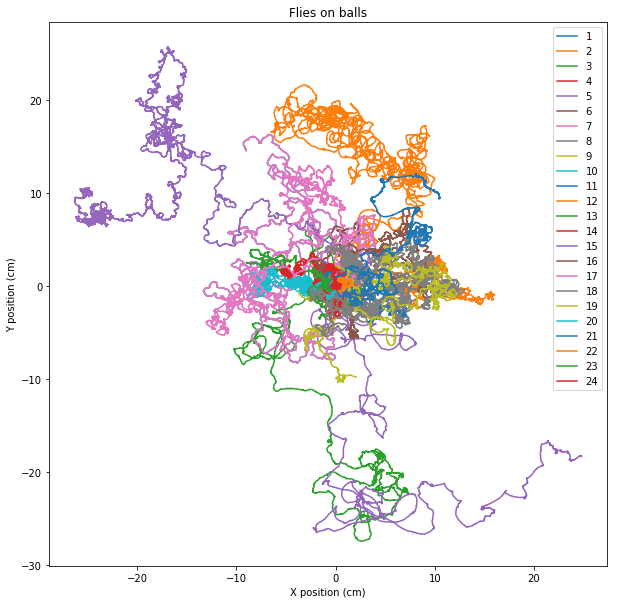

In [10]:
sphere_radius = 4.5e-3
plt.figure(figsize=(10,10))

for i in range(len(fictracs)):
    plt.plot(fictracs[i]['positionX']*sphere_radius*100, fictracs[i]['positionY']*sphere_radius*100, label = i+1)
    #plt.xlim(-10,45)
    #plt.ylim(-40,15)
    plt.xlabel('X position (cm)')
    plt.ylabel('Y position (cm)')
    plt.legend()
    plt.title('Flies on balls')
    #plt.savefig('myimage300.png', format='png', dpi=300)
plt.show()

In [ ]:
#rotation is in radians

In [ ]:
fictracs[0]['']

In [ ]:
# lets just deal with dRotLab since I am most confident in those units


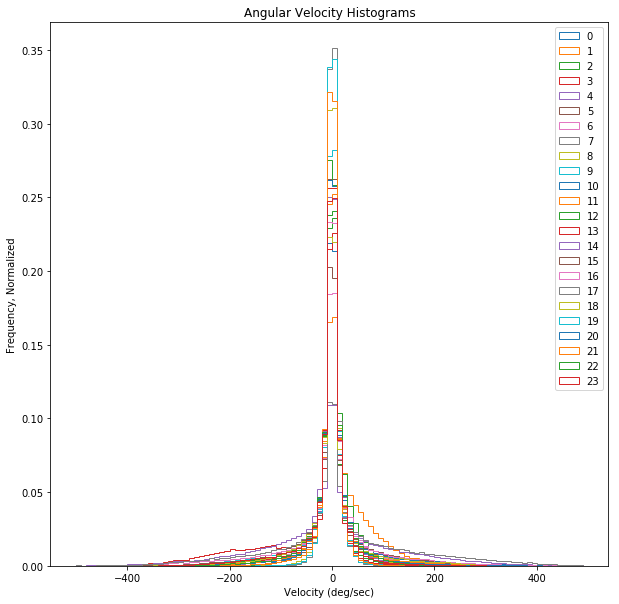

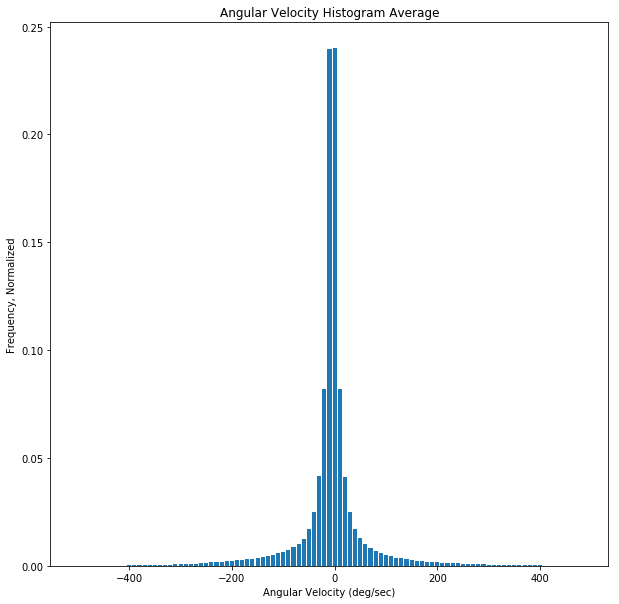

In [19]:
########################################
### Plot Angular Velocity Histograms ###
########################################

bins = np.ndarray.tolist(np.arange(-500,500,10))
fig = plt.figure(figsize=(10,10))
behavior = 'dRotLabZ'
sphere_radius = 4.5e-3
binned_data = []
for i in range(len(fictracs)):
    vector = np.rad2deg(fictracs[i][behavior]) # now in deg per 20ms
    vector = vector * 50 # now in deg per sec
    weights = np.ones_like(vector)/float(len(vector))
    binned,throwaway,throwaway2=plt.hist(vector,bins,weights=weights,label = str(i),stacked=True, histtype = 'step')
    binned_data.append(binned)
plt.legend()
#plt.xlim(.01,5)
plt.xlabel("Velocity (deg/sec)")
plt.ylabel("Frequency, Normalized")
plt.title("Angular Velocity Histograms")

avg_vel=np.ndarray.tolist(np.mean(np.asarray(binned_data),0))
fig = plt.figure(figsize=(10,10))
plt.bar(bins[:-1],avg_vel,width=8)
#plt.xlim(.01,5)
plt.xlabel("Angular Velocity (deg/sec)")
plt.ylabel("Frequency, Normalized")
plt.title("Angular Velocity Histogram Average")
plt.show()

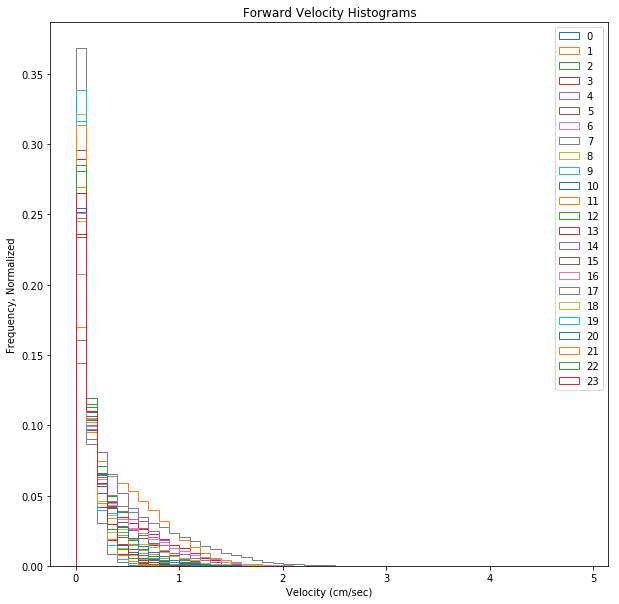

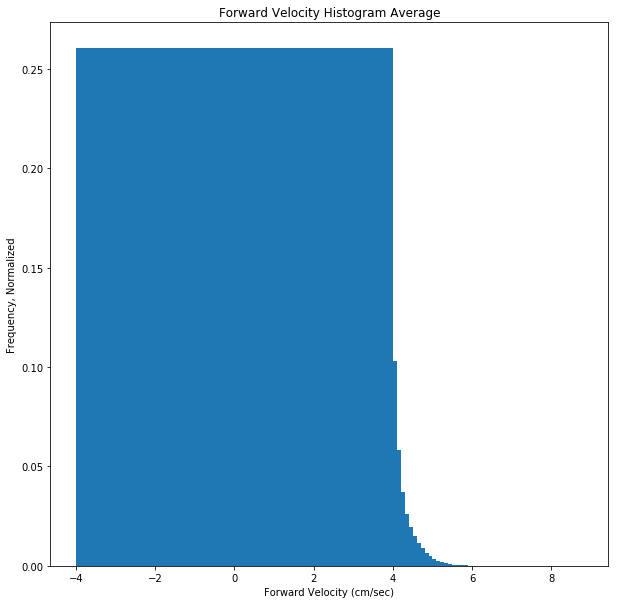

In [21]:
########################################
### Plot Forward Velocity Histograms ###
########################################

bins = np.ndarray.tolist(np.arange(0,5,.1))
fig = plt.figure(figsize=(10,10))
behavior = 'dRotLabY'
sphere_radius = 4.5e-3
binned_data = []
for i in range(len(fictracs)):
    vector = fictracs[i][behavior]*sphere_radius # now in m per 20ms
    vector = vector * 100 * 50 # now in cm per sec
    weights = np.ones_like(vector)/float(len(vector))
    binned,throwaway,throwaway2=plt.hist(vector,bins,weights=weights,label = str(i),stacked=True, histtype = 'step')
    binned_data.append(binned)
plt.legend()
#plt.xlim(.01,5)
plt.xlabel("Velocity (cm/sec)")
plt.ylabel("Frequency, Normalized")
plt.title("Forward Velocity Histograms")

avg_vel=np.ndarray.tolist(np.mean(np.asarray(binned_data),0))
fig = plt.figure(figsize=(10,10))
plt.bar(bins[:-1],avg_vel,width=8)
#plt.xlim(.01,5)
plt.xlabel("Forward Velocity (cm/sec)")
plt.ylabel("Frequency, Normalized")
plt.title("Forward Velocity Histogram Average")
plt.show()

In [24]:
from scipy.ndimage.interpolation import shift

<Figure size 720x720 with 0 Axes>

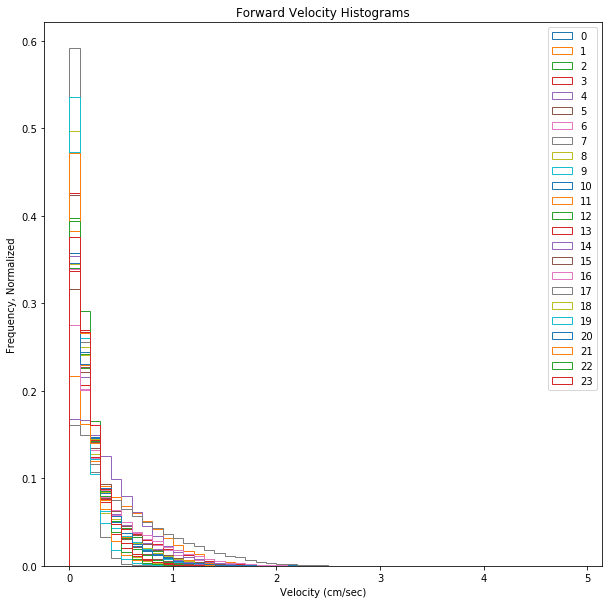

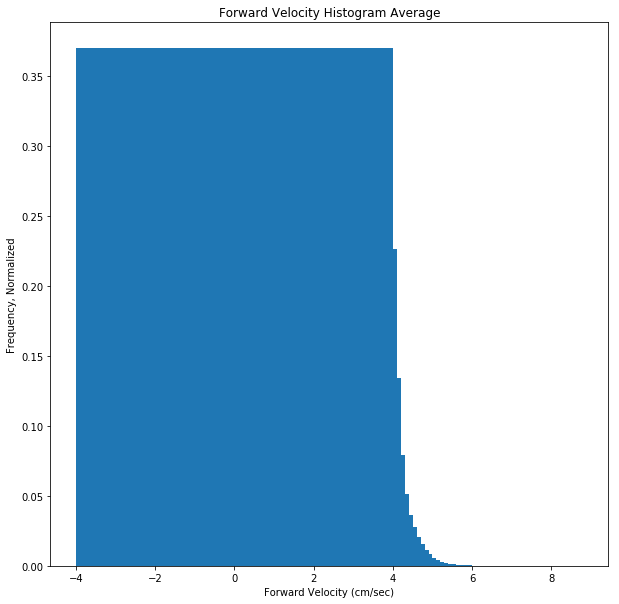

In [25]:
########################################
### Plot Forward Velocity Histograms ###
########################################

bins = np.ndarray.tolist(np.arange(0,5,.1))
fig = plt.figure(figsize=(10,10))
behavior = 'dRotLabY'
sphere_radius = 4.5e-3
binned_data = []
for i in range(len(fictracs)):
    x1 = fictracs[i]['positionX']*sphere_radius*100 #in cm
    y1 = fictracs[i]['positionY']*sphere_radius*100 #in cm

    x2 = shift(x1,-1,cval=np.NaN)
    y2 = shift(y1,-1,cval=np.NaN)

    # Calculate velocity
    dist = (((x2-x1)**2)+((y2-y1)**2))**0.5
    vector = dist[:-2]
    vector = vector * 50 # now in cm/sec
    
    weights = np.ones_like(vector)/float(len(vector))
    binned,throwaway,throwaway2=plt.hist(vector,bins,weights=weights,label = str(i),stacked=True, histtype = 'step')
    binned_data.append(binned)
plt.legend()
#plt.xlim(.01,5)
plt.xlabel("Velocity (cm/sec)")
plt.ylabel("Frequency, Normalized")
plt.title("Forward Velocity Histograms")

avg_vel=np.ndarray.tolist(np.mean(np.asarray(binned_data),0))
fig = plt.figure(figsize=(10,10))
plt.bar(bins[:-1],avg_vel,width=8)
#plt.xlim(.01,5)
plt.xlabel("Forward Velocity (cm/sec)")
plt.ylabel("Frequency, Normalized")
plt.title("Forward Velocity Histogram Average")
plt.show()

In [86]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
desired_flies = [15,17,19,22,23,24,25,26] # 1 index
folders = get_fly_folders(root_path, desired_flies)
print(folders)

fly folders: ['fly_15', 'fly_17', 'fly_19', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']
['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_15', '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_17', '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19', '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_22', '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_23', '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_24', '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25', '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_26']


In [87]:
anatomy_files = []
for folder in folders:
    anatomy_files.append(os.path.join(folder, 'anatomy.nii'))

brains = []
for brain_file in anatomy_files:
    full_file = os.path.join(root_path, brain_file)
    brains.append(load_numpy_brain(full_file))

# rotate brains
for i in range(len(brains)):
    brains[i] = np.swapaxes(brains[i],0,1)

In [88]:
anatomy_xml_files = []
for folder in folders:
    anatomy_xml_files.append(os.path.join(folder, 'anatomy.xml'))

In [89]:
anatomy_xml_files = []
for folder in folders:
    anatomy_xml_files.append(os.path.join(folder, 'anatomy.xml'))

brain_ants = []
for i in range(len(brains)):
    print(i)
    ants_brain = ants.from_numpy(brains[i])
    ants_brain.set_spacing(get_resolution(anatomy_xml_files[i]))
    ants_brain = ants.n4_bias_field_correction(ants_brain)
    brain_ants.append(ants_brain)

0
1
2
3
4
5
6
7


In [18]:
3

3

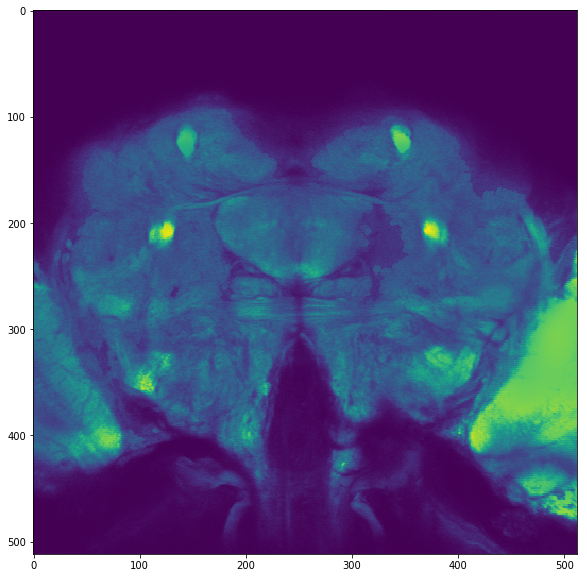

In [90]:
plt.figure(figsize=(10,10))
plt.imshow(brain_ants[5].numpy()[:,:,100])
plt.show()

In [8]:
master = ants.from_numpy(meanbrain)

In [11]:
file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/', '20190101_walking_dataset', 'fly_24', 'anatomy.xml')

In [15]:
brain_ants = []
for i in range(len(brains)):
    print(i)
    ants_brain = ants.from_numpy(warps2[i])
    ants_brain.set_spacing(get_resolution(anatomy_xml_files[i]))
    ants_brain = ants.n4_bias_field_correction(ants_brain)
    brain_ants.append(ants_brain)

NameError: name 'brains' is not defined

In [12]:
master.set_spacing((get_resolution(file)))

In [17]:
warps = []
for i in range(len(warps2)):
    t0 = time()
    slave = ants.from_numpy(warps2[i])
    slave2master = ants.registration(master,
                                     slave,
                                     type_of_transform='SyN')
    warps.append(slave2master)
    print(time() - t0)

431.34121680259705
490.66609954833984
502.8086664676666
500.37869024276733
436.9844172000885
440.4870240688324
421.4161305427551
421.9913749694824


In [93]:
for i in range(len(brains)):
    save_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/', '20190224_anatomy_central', '20190318_meanbrain', 'affine2', 'affine_' + str(i) + '.nii')
    save_brain(save_file, warps[i]['warpedmovout'].numpy())

In [2]:
warps2 = []
for i in range(8):
    file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/', '20190224_anatomy_central', '20190318_meanbrain', 'affine2', 'affine_' + str(i) + '.nii')
    warps2.append(load_numpy_brain(file))

In [3]:
warps3 = []
for i in range(8):
    temp = ants.from_numpy(warps2[i])
    temp = ants.smooth_image(temp, sigma=1)
    warps3.append(temp.numpy())

In [4]:
brains_to_average = np.asarray(warps3)
meanbrain = np.mean(brains_to_average, axis=0)

In [7]:
save_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/', '20190224_anatomy_central', '20190318_meanbrain', 'affine2', 'mean.nii')
save_brain(save_file, meanbrain)

In [6]:
from bigbrain.brain import get_resolution
from bigbrain.brain import save_brain

In [ ]:
master_ants = ants.from_numpy(brains[1])
master_ants.set_spacing((0.768, 0.768, 1))
slave_ants = ants.from_numpy(brains[0])
slave_ants.set_spacing((0.768, 0.768, 1))

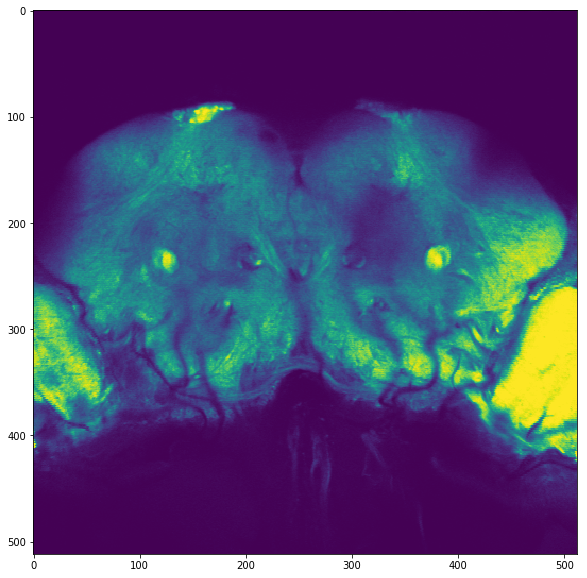

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(brains[1][:,:,70])
plt.show()

In [44]:
master_n4 = ants.n4_bias_field_correction(master_ants)
slave_n4 = ants.n4_bias_field_correction(slave_ants)

In [49]:
t0 = time()
slave2master = ants.registration(master_n4,
                                 slave_n4,
                                 type_of_transform='Affine')
print(time() - t0)

91.51939105987549


In [50]:
save_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/', '20190224_anatomy_central', '20190318_meanbrain', 'slave2_24master_affine.nii')
save_brain(save_file, slave2master['warpedmovout'].numpy())

In [30]:
from bigbrain.brain import save_brain

In [ ]:

grad_step=0.2,
                                 flow_sigma=10,
                                 total_sigma=3,